In [1]:
# compare_rnn_lstm_gru_with_eval.py
# Notebook-ready: trains RNN, LSTM, GRU on wiki_train/valid/test,
# logs to TensorBoard, plots combined loss graphs for each model,
# evaluates test set with Loss, PPL, Accuracy, CER, WER, and samples text.

import os
import math
import time
import random
from collections import defaultdict

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

In [2]:
# ----------------------
# Utility: edit distance (Levenshtein)
# ----------------------
def levenshtein(a: str, b: str) -> int:
    # classic dynamic programming
    la, lb = len(a), len(b)
    if la == 0: return lb
    if lb == 0: return la
    dp = [[0] * (lb + 1) for _ in range(la + 1)]
    for i in range(la + 1):
        dp[i][0] = i
    for j in range(lb + 1):
        dp[0][j] = j
    for i in range(1, la + 1):
        for j in range(1, lb + 1):
            cost = 0 if a[i-1] == b[j-1] else 1
            dp[i][j] = min(dp[i-1][j] + 1,      # deletion
                           dp[i][j-1] + 1,      # insertion
                           dp[i-1][j-1] + cost) # substitution
    return dp[la][lb]

In [3]:
def cer(reference: str, hypothesis: str) -> float:
    # Character error rate (chars)
    if len(reference) == 0:
        return float(len(hypothesis) > 0)
    return levenshtein(reference, hypothesis) / len(reference)

In [4]:
def wer(reference: str, hypothesis: str) -> float:
    # Word error rate (words)
    r_words = reference.split()
    h_words = hypothesis.split()
    if len(r_words) == 0:
        return float(len(h_words) > 0)
    # map lists to tokens joined by sentinel for Levenshtein at word-level
    # simpler: compute DP on words
    la, lb = len(r_words), len(h_words)
    dp = [[0] * (lb + 1) for _ in range(la + 1)]
    for i in range(la + 1):
        dp[i][0] = i
    for j in range(lb + 1):
        dp[0][j] = j
    for i in range(1, la + 1):
        for j in range(1, lb + 1):
            cost = 0 if r_words[i-1] == h_words[j-1] else 1
            dp[i][j] = min(dp[i-1][j] + 1,
                           dp[i][j-1] + 1,
                           dp[i-1][j-1] + cost)
    return dp[la][lb] / la

In [5]:
# ----------------------
# 1) Dataset (shared vocab from train)
# ----------------------
class WikiWordsDataset(Dataset):
    def __init__(self, tokens_ids, seq_length):
        # tokens_ids: 1D torch tensor of token ids (already mapped by vocab)
        self.data = tokens_ids
        self.seq_length = seq_length

    def __len__(self):
        return max(0, len(self.data) - self.seq_length)

    def __getitem__(self, idx):
        x = self.data[idx: idx + self.seq_length]
        y = self.data[idx + 1: idx + 1 + self.seq_length]
        return x, y

In [6]:
def build_vocab_from_text(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()
    tokens = text.lower().split()
    # build vocab sorted for determinism
    freq = {}
    for t in tokens:
        freq[t] = freq.get(t, 0) + 1
    # reserve 0 for <unk>
    stoi = {"<unk>": 0}
    itos = {0: "<unk>"}
    idx = 1
    for w in sorted(freq.keys()):
        if w not in stoi:  # skip if already in vocab (e.g., <unk>)
            stoi[w] = idx
            itos[idx] = w
            idx += 1
    return stoi, itos, tokens

In [7]:
def tokens_to_ids(tokens, stoi):
    return torch.tensor([stoi.get(t, 0) for t in tokens], dtype=torch.long)

In [8]:
# ----------------------
# 2) Model class (shared interface)
# ----------------------
class SeqLM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, model_type="rnn", num_layers=1):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=None)
        self.model_type = model_type.lower()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        if self.model_type == "rnn":
            self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        elif self.model_type == "lstm":
            self.rnn = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        elif self.model_type == "gru":
            self.rnn = nn.GRU(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        else:
            raise ValueError("model_type must be rnn/lstm/gru")
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        # x: (batch, seq_len)
        emb = self.embed(x)  # (batch, seq_len, embed_dim)
        out, hidden = self.rnn(emb, hidden)
        logits = self.fc(out)  # (batch, seq_len, vocab)
        return logits, hidden

    def init_hidden(self, batch_size, device):
        shape = (self.num_layers, batch_size, self.hidden_dim)
        h0 = torch.zeros(*shape, device=device)
        if self.model_type == "lstm":
            c0 = torch.zeros(*shape, device=device)
            return (h0, c0)
        else:
            return h0

In [9]:
# ----------------------
# 3) Training & evaluation helpers
# ----------------------

In [10]:
def detach_hidden(hidden):
    if isinstance(hidden, tuple):
        return tuple(h.detach() for h in hidden)
    else:
        return hidden.detach()

In [11]:

def evaluate_on_loader(model, loader, criterion, vocab_size, device, stoi, itos):
    model.eval()
    total_loss = 0.0
    total_tokens = 0
    total_correct = 0

    # For sequence-level CER/WER, accumulate references and hypotheses across batches
    refs = []
    hyps = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            batch_size = x.size(0)
            hidden = model.init_hidden(batch_size, device)
            logits, _ = model(x, hidden)  # (batch, seq, vocab)
            vocab = logits.size(-1)
            loss = criterion(logits.view(-1, vocab), y.view(-1))
            total_loss += loss.item() * x.numel()
            total_tokens += x.numel()

            preds = logits.argmax(dim=-1)  # (batch, seq)
            total_correct += (preds == y).sum().item()

            # For CER/WER: convert each sequence to words and chars
            # map ids to words; unknown ids handled by itos
            for b in range(batch_size):
                ref_words = [itos.get(int(t.item()), "<unk>") for t in y[b]]
                hyp_words = [itos.get(int(t.item()), "<unk>") for t in preds[b]]
                refs.append(" ".join(ref_words))
                hyps.append(" ".join(hyp_words))

    avg_loss = total_loss / total_tokens
    perplexity = math.exp(avg_loss)
    accuracy = total_correct / total_tokens

    # compute aggregated CER & WER across sequences
    total_cer = 0.0
    total_wer = 0.0
    for r, h in zip(refs, hyps):
        total_cer += cer(r.replace(" ", ""), h.replace(" ", ""))  # char-level (no spaces)
        total_wer += wer(r, h)
    mean_cer = total_cer / len(refs) if refs else 0.0
    mean_wer = total_wer / len(refs) if refs else 0.0

    return avg_loss, perplexity, accuracy, mean_cer, mean_wer, refs, hyps

In [12]:

def greedy_generate(model, prompt_tokens, stoi, itos, max_len, device):
    # prompt_tokens: list of token strings; map to ids
    model.eval()
    ids = [stoi.get(t, 0) for t in prompt_tokens]
    cur = torch.tensor([ids], dtype=torch.long, device=device)  # (1, prompt_len)
    hidden = model.init_hidden(1, device)
    generated = prompt_tokens.copy()
    with torch.no_grad():
        # feed entire prompt first (to set hidden)
        logits, hidden = model(cur, hidden)
        last_id = int(cur[0, -1].item())
        for _ in range(max_len):
            inp = torch.tensor([[last_id]], dtype=torch.long, device=device)
            logits, hidden = model(inp, hidden)
            probs = torch.softmax(logits[:, -1, :], dim=-1)  # (1, vocab)
            next_id = int(probs.argmax(dim=-1).item())  # greedy
            generated.append(itos.get(next_id, "<unk>"))
            last_id = next_id
            if len(generated) >= max_len + len(ids):
                break
    return " ".join(generated)

In [13]:
# ----------------------
# 4) Main experiment routine
# ----------------------
def run_experiment(
    train_file,
    valid_file,
    test_file,
    seq_length=30,
    batch_size=64,
    embed_dim=128,
    hidden_dim=256,
    num_layers=1,
    epochs=6,
    lr=1e-3,
    device=None,
    random_seed=42,
):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    if device.startswith("cuda"):
        torch.cuda.manual_seed_all(random_seed)

    # Build vocab from train
    print("Building vocab from train...")
    stoi, itos, train_tokens = build_vocab_from_text(train_file)
    vocab_size = len(stoi)
    print(f"Vocab size (including <unk>=0): {vocab_size}")

    # Map train/val/test to ids (use train vocab; unseen => <unk>)
    print("Mapping tokens to ids...")
    train_ids = tokens_to_ids(train_tokens, stoi)
    with open(valid_file, 'r', encoding='utf-8') as f:
        val_tokens = f.read().lower().split()
    val_ids = tokens_to_ids(val_tokens, stoi)
    with open(test_file, 'r', encoding='utf-8') as f:
        test_tokens = f.read().lower().split()
    test_ids = tokens_to_ids(test_tokens, stoi)

    # Datasets & loaders
    train_ds = WikiWordsDataset(train_ids, seq_length)
    val_ds = WikiWordsDataset(val_ids, seq_length)
    test_ds = WikiWordsDataset(test_ids, seq_length)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)
    test_loader = DataLoader(test_ds, batch_size=batch_size)

    model_types = ["rnn", "lstm", "gru"]
    all_results = {}

    for model_type in model_types:
        print("\n" + "="*30)
        print(f"Training model: {model_type.upper()}")
        print("="*30)
        model = SeqLM(vocab_size, embed_dim, hidden_dim, model_type=model_type, num_layers=num_layers).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        writer = SummaryWriter(log_dir=f"runs/{model_type.upper()}_{int(time.time())}")

        # store epoch-level metrics for plotting
        epoch_train_losses = []
        epoch_val_losses = []
        epoch_val_ppls = []

        for epoch in range(1, epochs + 1):
            model.train()
            t0 = time.time()
            running_loss = 0.0
            tokens_seen = 0
            for x, y in train_loader:
                x = x.to(device)
                y = y.to(device)
                bsz = x.size(0)
                hidden = model.init_hidden(bsz, device)
                optimizer.zero_grad()
                logits, _ = model(x, hidden)
                loss = criterion(logits.view(-1, vocab_size), y.view(-1))
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()

                running_loss += loss.item() * x.numel()
                tokens_seen += x.numel()

            train_loss = running_loss / tokens_seen if tokens_seen > 0 else float("nan")
            val_loss, val_ppl, _, _, _, _, _ = evaluate_on_loader(model, val_loader, criterion, vocab_size, device, stoi, itos)

            epoch_train_losses.append(train_loss)
            epoch_val_losses.append(val_loss)
            epoch_val_ppls.append(val_ppl)

            writer.add_scalar("Loss/Train", train_loss, epoch)
            writer.add_scalar("Loss/Validation", val_loss, epoch)
            writer.add_scalar("Perplexity/Validation", val_ppl, epoch)

            t1 = time.time()
            print(f"{model_type.upper()} Epoch {epoch}/{epochs} | Train Loss={train_loss:.4f} | Val Loss={val_loss:.4f} | Val PPL={val_ppl:.2f} | time={t1-t0:.1f}s")

        # After training, evaluate on test set
        test_loss, test_ppl, test_acc, test_cer, test_wer, refs, hyps = evaluate_on_loader(
            model, test_loader, criterion, vocab_size, device, stoi, itos)

        writer.add_scalar("Loss/Test", test_loss, epochs)
        writer.add_scalar("Perplexity/Test", test_ppl, epochs)
        writer.add_scalar("Accuracy/Test", test_acc, epochs)
        writer.add_scalar("CER/Test", test_cer, epochs)
        writer.add_scalar("WER/Test", test_wer, epochs)
        writer.close()

        # Generate some sample text from a few prompts drawn from test tokens
        samples = []
        # create few prompt tokens (3-5 tokens) from test tokens at random positions
        for i in range(3):
            pos = random.randint(0, max(0, len(test_tokens) - 6))
            prompt = test_tokens[pos: pos + 3]
            gen = greedy_generate(model, prompt, stoi, itos, max_len=30, device=device)
            samples.append((" ".join(prompt), gen))

        # Save results
        all_results[model_type.upper()] = {
            "train_losses": epoch_train_losses,
            "val_losses": epoch_val_losses,
            "val_ppls": epoch_val_ppls,
            "test_loss": test_loss,
            "test_ppl": test_ppl,
            "test_acc": test_acc,
            "test_cer": test_cer,
            "test_wer": test_wer,
            "samples": samples,
            "refs": refs[:5],  # first few references (for quick debug)
            "hyps": hyps[:5],
        }

        # Print immediate test summary
        print(f"\n*** {model_type.upper()} TEST RESULTS ***")
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Test Perplexity: {test_ppl:.2f}")
        print(f"Token Accuracy: {test_acc*100:.3f}%")
        print(f"CER: {test_cer:.4f}")
        print(f"WER: {test_wer:.4f}")
        print("Sample generations (prompt -> generation):")
        for p, g in samples:
            print(f"PROMPT: {p}\nGEN: {g}\n")

    # ----------------------
    # Plot: For each model, show Train & Val Loss on the same subplot
    # ----------------------
    plt.figure(figsize=(15, 10))
    model_keys = list(all_results.keys())
    for i, m in enumerate(model_keys, 1):
        plt.subplot(3, 1, i)
        res = all_results[m]
        epochs_range = range(1, len(res["train_losses"]) + 1)
        plt.plot(epochs_range, res["train_losses"], label=f"{m} Train Loss", marker='o')
        plt.plot(epochs_range, res["val_losses"], label=f"{m} Val Loss", marker='x')
        plt.title(f"{m}: Train vs Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ----------------------
    # Print final summary table
    # ----------------------
    print("\n\nFINAL TEST METRIC SUMMARY")
    print("{:<8} {:>10} {:>12} {:>12} {:>10} {:>10}".format("Model", "TestLoss", "TestPPL", "Accuracy", "CER", "WER"))
    print("-" * 70)
    for m in model_keys:
        r = all_results[m]
        print("{:<8} {:>10.4f} {:>12.2f} {:>12.4f} {:>10.4f} {:>10.4f}".format(
            m, r["test_loss"], r["test_ppl"], r["test_acc"], r["test_cer"], r["test_wer"]
        ))

    # Show a few sample generations per model
    print("\n\nSAMPLE GENERATIONS (per model):")
    for m in model_keys:
        print("\n===", m, "===")
        for prompt, gen in all_results[m]["samples"]:
            print(f"PROMPT: {prompt}\nGEN: {gen}\n")

    return all_results

In [14]:
base_dir = "."
fraction = 0.1

# Define file paths
train_path = os.path.join(base_dir, "wiki_train.txt")
valid_path = os.path.join(base_dir, "wiki_valid.txt")
test_path = os.path.join(base_dir, "wiki_test.txt")

def subset_file(input_path, output_path, fraction):
    with open(input_path, "r", encoding="utf-8") as f:
        text = f.read()
    
    subset_length = int(len(text) * fraction)
    subset_text = text[:subset_length]  # take first 10% of the text
    
    with open(output_path, "w", encoding="utf-8") as f:
        f.write(subset_text)
    
    print(f"✅ Created subset {output_path} ({subset_length} characters, {fraction*100:.1f}% of original)")

# Save subset files
subset_file(train_path, os.path.join(base_dir, "wiki_train_subset.txt"), fraction)
subset_file(valid_path, os.path.join(base_dir, "wiki_valid_subset.txt"), fraction)
subset_file(test_path, os.path.join(base_dir, "wiki_test_subset.txt"), fraction)

✅ Created subset ./wiki_train_subset.txt (1078043 characters, 10.0% of original)
✅ Created subset ./wiki_valid_subset.txt (112019 characters, 10.0% of original)
✅ Created subset ./wiki_test_subset.txt (125501 characters, 10.0% of original)


Device: cpu
Building vocab from train...
Vocab size (including <unk>=0): 13433
Mapping tokens to ids...

Training model: RNN
RNN Epoch 1/6 | Train Loss=4.0537 | Val Loss=6.3801 | Val PPL=589.97 | time=437.9s
RNN Epoch 2/6 | Train Loss=1.9457 | Val Loss=7.5769 | Val PPL=1952.62 | time=453.6s
RNN Epoch 3/6 | Train Loss=1.2904 | Val Loss=8.5114 | Val PPL=4970.92 | time=460.5s
RNN Epoch 4/6 | Train Loss=1.0048 | Val Loss=9.2576 | Val PPL=10483.74 | time=464.4s
RNN Epoch 5/6 | Train Loss=0.8511 | Val Loss=9.8358 | Val PPL=18690.52 | time=471.8s
RNN Epoch 6/6 | Train Loss=0.7564 | Val Loss=10.3158 | Val PPL=30205.50 | time=470.9s

*** RNN TEST RESULTS ***
Test Loss: 10.1266
Test Perplexity: 24998.23
Token Accuracy: 12.427%
CER: 0.7939
WER: 0.8734
Sample generations (prompt -> generation):
PROMPT: long , including
GEN: long , including four of them , b. b. lal , later commenting that " behind the <unk> exterior , sir mortimer had a very kind and sympathetic heart " . throughout his

PROMPT: a

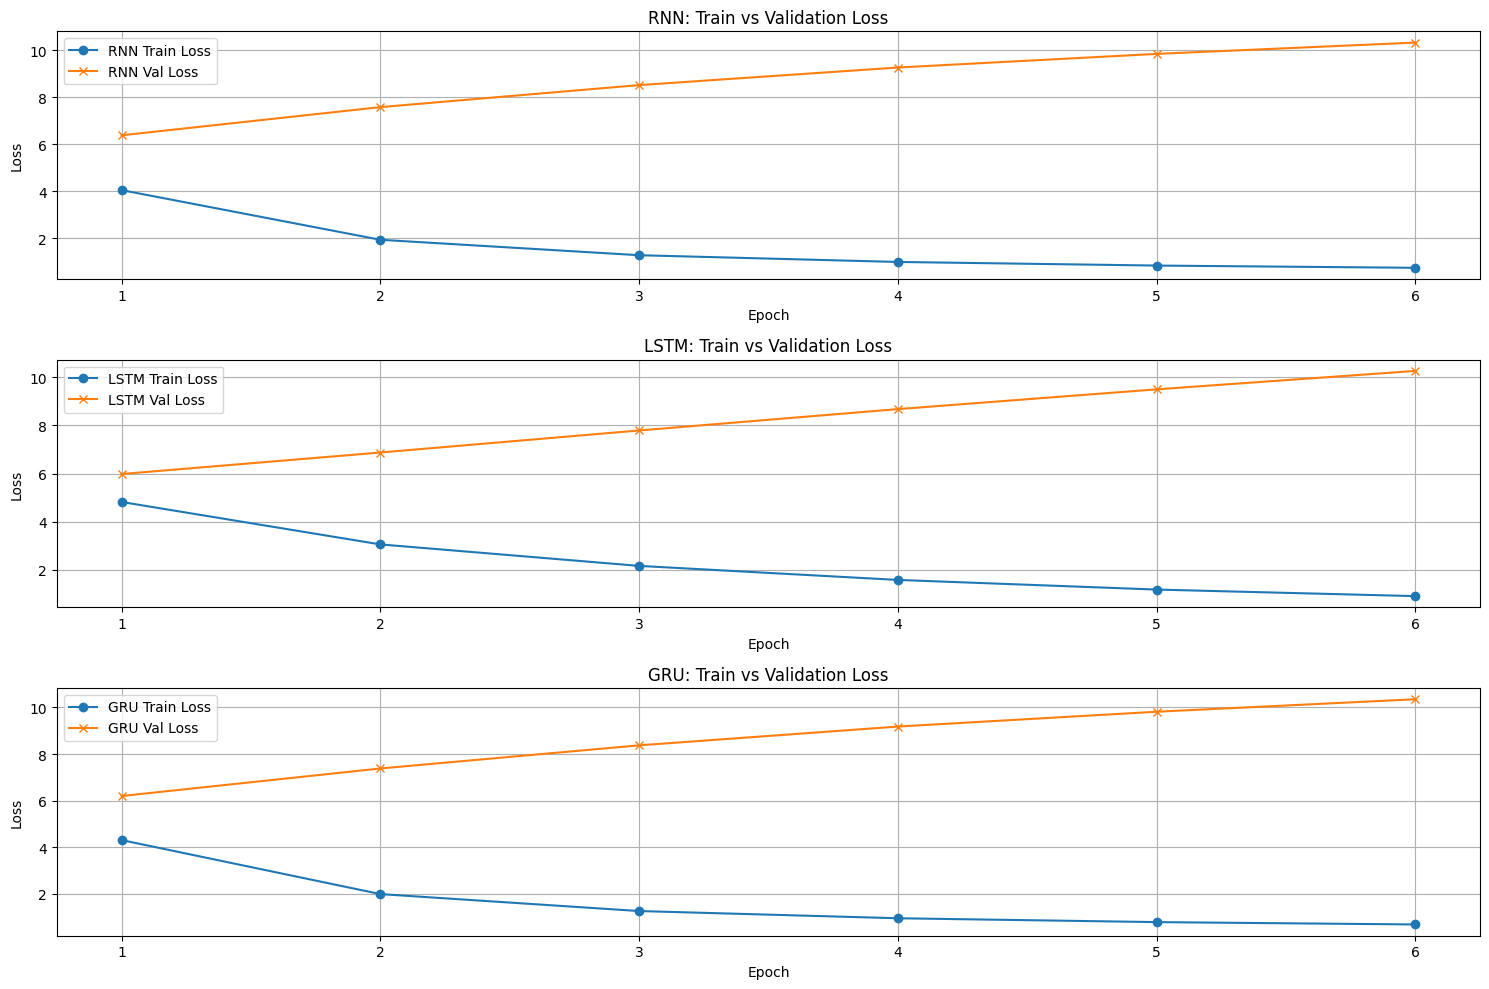



FINAL TEST METRIC SUMMARY
Model      TestLoss      TestPPL     Accuracy        CER        WER
----------------------------------------------------------------------
RNN         10.1266     24998.23       0.1243     0.7939     0.8734
LSTM         9.9428     20802.25       0.1385     0.7819     0.8591
GRU         10.1740     26211.80       0.1269     0.7928     0.8710


SAMPLE GENERATIONS (per model):

=== RNN ===
PROMPT: long , including
GEN: long , including four of them , b. b. lal , later commenting that " behind the <unk> exterior , sir mortimer had a very kind and sympathetic heart " . throughout his

PROMPT: an <unk> "
GEN: an <unk> " but highlighted the material about $ 5 million . massachusetts , particularly cape cod and nantucket , bore the brunt of the nor 'easter . reportedly , wind gusts approached

PROMPT: review of the
GEN: review of the leading to the german heritage of all three . along with his command on the western united states for it struck the western part . eat

In [15]:
# ----------------------
# If running in notebook, call run_experiment()
# ----------------------
if __name__ == "__main__":
    results = run_experiment(
        "wiki_train_subset.txt",
        "wiki_valid_subset.txt",
        "wiki_test_subset.txt",
        seq_length=30,
        batch_size=64,
        embed_dim=128,
        hidden_dim=256,
        num_layers=1,
        epochs=6,
        lr=1e-3,
        device=None,
        random_seed=42,
    )